(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Yelp Reviews and Clustering

In this assignment, we will be working with the [Yelp dataset](http://cs-people.bu.edu/kzhao/teaching/yelp_dataset_challenge_academic_dataset.tar). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

First, we will look at Review Objects and perform some [sentiment analysis](http://sentiment.christopherpotts.net/) on the review text.

You will need to preprocess the text using a stemming algorithm. The Porter stemming algorithm is a well-known one. Then, use a lexicon to assign a score to a review based on the positive/negative words you find in the text. You can find various lexicons [here](http://sentiment.christopherpotts.net/lexicons.html).

After you have assigned scores to the reviews based on the text analysis, compare your scores with the stars associated with the reviews. **(20 pts)**

In [ ]:
import unicodedata
import json
import pandas as pd
from nltk.corpus import stopwords
import nltk
from nltk.stem import *
import copy

#Parse json file and create list of stars and text for each review.
def parsedata(filename):

    data = open(filename)
    stars = []
    text = []
    stopWords = stopwords.words("english")
    review = []
    for line in data:
        reviews = json.loads(line)
        stars.append(reviews['stars'])
        text.append(reviews['text'])   

    data.close()


    dicts = []

    for i in range(0,len(stars)):
        review.append([stars[i], text[i]])


    stars = None
    text = None

    return review
abcd = parsedata('yelp_academic_dataset_review.json')

In [ ]:
#Vader Lexicon: Use the Vader Lexicon, to assign a score for each text review. This part may take 20-40 min to run
edcba = copy.deepcopy(abcd)
def scoretext(lsts):
    lexdix = {}
    score= []
    stars = []
    dicts = []
    with open('vader_lexicon.txt') as lexicon:
        for line in lexicon:
            entry = line.split()
            if entry:
                lexdix.update({entry[0]: entry[1]})       
        for j in lsts:
            k = float(0)
            stars.append(j[0])
            tmpscore = float(0)
            j[1] = j[1].split()
            for i in j[1]:
                if i in lexdix:
                    k = k+1
                    tmpscore = tmpscore + float(lexdix.get(i))
            score.append(k*tmpscore)
            
        for i in range(0,len(stars)):
            review = {'stars' : stars[i], 'score' : score[i]}
            dicts.append(review)

        dataframe = pd.DataFrame(dicts, columns = ['stars', 'score'])
        dicts = None
#return  a dataframe of stars with the corresponding score
        return (dataframe)

df = scoretext(edcba)
print(df)

Visualization and short (detailed) analysis. **(10 pts)**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
#plot the score to stars scatter plots
plotdf = df.copy()  
one = 0
o = 0
two = 0
tw = 0
three = 0
th = 0
four = 0
fo = 0
five = 0
fi =0
for index, row in plotdf.iterrows():
    if row['stars'] == 1:
        one = one + row['score']
        o = o+1
    if row['stars'] == 2:
        two = two + row['score']
        tw = tw +1
    if row['stars'] == 3:
        three = three + row['score']
        th = th +1
    if row['stars'] == 4:
        four = four + row['score']
        fo = fo +1
    if row['stars'] == 5:
        five = five + row['score']
        fi = fi+1
one = one/o
two = two/tw
three = three/th
four = four/fo
five = five/fi
#plot the average score per star to number of stars
dframe = pd.DataFrame([[1,one],[2,two],[3,three],[4,four],[5,five]], columns = ['stars', 'score'])
print (dframe)

In [ ]:
df.plot('stars', 'score', 'scatter')
dframe.plot('stars', 'score', 'line')
#As we see in the first plot, using the Vader Lexicon is not an efficient predictor for the stars given by the reviewer.
#Vader assigns a score to each word in the review if in the lexicon. Then we add the scores for each word in the review and multiply by the number of words 
#of the review that are indeed in the lexicon, to yield a raw score. The reason why reviews with low stars may get a high score, could be the fact that they have many words 
#in the lexicon, and their raw score ends up being positive, and the when multiplied by the number of words yields a large score (words like "like" for example)
#The reason why many reviews with a good star rating end up with a low score could be the fact that there are not many words or even none of the review
#in the lexicon thus yielding a low raw score.
#However as we see in the second plot, which is a plot of average score per stars, 
#the relationship is increasing, meaning that our method does a good job for a good amount of the reviews. It cannot however distinguish 
#very well the difference between 4 and 5 stars. I believe there are better alternatives to Vader

-----------------

Now, let's look at Business Objects. Try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" and "attributes" to cluster for similarity.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

Things you may want to consider:
1. The spatial coordinates and restaurant categories/attributes have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.
2. Some restaurant types are inherently more common than others. For example, there are probably lots of "pizza" restaurants. You may want to normalize your vectors so that you don't end up with only clusters of "pizza" restaurants.

In [64]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from sklearn.feature_extraction import DictVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
import sklearn.cluster as cluster
from scipy.cluster.hierarchy import cophenet
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import pdist
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn import mixture
from __future__ import print_function
from nltk.stem import *
from nltk.corpus import stopwords
import json
import sys
from collections import Counter
%matplotlib inline

#returns the information for each restaurant. We use around 160 restaurant categories to categorize the LV restaurants
#We also use latitude and longitude, price range(1-5) and take-out(0 for no, 1 for yes). there is need for scaling
def getBusiness(filename):
    
    yelp_dataset = open(filename)
    lv_restaurants = []
    
    for line in yelp_dataset:
        current_business = json.loads(line)
        if ("Restaurants" in current_business['categories']) and (current_business['city'] == "Las Vegas") and ('Price Range' in current_business['attributes'].keys()) and ('Take-out' in current_business['attributes'].keys()) :
            restaurant_info = {'latitude' : current_business['latitude'], 'longitude' : current_business['longitude'], 'categories' : current_business['categories'], 'price range' : (current_business['attributes']['Price Range']), 'takeout': (current_business['attributes']['Take-out'])}
            lv_restaurants.append(restaurant_info)
    
    
        
    yelp_dataset.close()
    return lv_restaurants

In [65]:
#returns list of all categories
def getTypes(filename):
    
    yelp_dataset = open(filename)
    restaurant_types = []
    
    for line in yelp_dataset:
        current_business = json.loads(line)
        if "Restaurants" in current_business['categories'] and current_business['city'] == "Las Vegas":
            for tag in current_business['categories']:
                if tag != "Restaurants" and not tag in restaurant_types:
                    restaurant_types.append(str(tag))
    
    yelp_dataset.close()
    return restaurant_types

In [66]:
#
def vectorizeRestaurants(restaurants, types):
    ss = 0
    for curr_restaurant in restaurants:
        ss=0
        for _type in types:
            if _type in curr_restaurant['categories']:
                curr_restaurant[_type] = 1
            else:
                curr_restaurant[_type] = 0
            ss = ss+1
        del curr_restaurant['categories']
    
    #Returns a final list of dictionaries with all the data that we need. Scaling has taken place. The values longitude, latitude
    #price range and takeout each appear around 80 times
    for curr_restaurant in restaurants:
        for i in range(0,ss):
            if i%2 == 0:
                curr_restaurant['longitude'+str(i)] = (curr_restaurant['longitude'])
                curr_restaurant['price range'+str(i)] = curr_restaurant['price range']
            if i%2 == 1:
                curr_restaurant['latitude'+str(i)] = curr_restaurant['latitude']
                curr_restaurant['takeout'+str(i)] = curr_restaurant['takeout']
    return restaurants

restaurants_lv = getBusiness('yelp_academic_dataset_business.json')
types_lv = getTypes('yelp_academic_dataset_business.json')
data = vectorizeRestaurants(restaurants_lv, types_lv)

In [67]:
#Create an array from our data
vector_arr = []
for d in data:
    lst =[]
    for key, value in d.iteritems():
        if value == True:
            lst.append(1)
        elif value == False:
            lst.append(0)
        else:
            lst.append(value)
    vector_arr.append(lst)

Visualize your clusters using each technique. Label your clusters. **(10 pts)**

The cluster's label defined by the green dots is Buffets
The cluster's label defined by the blue dots is American (Traditional)
The cluster's label defined by the red dots is Fast Food
The cluster's label defined by the yellow dots is Steakhouses


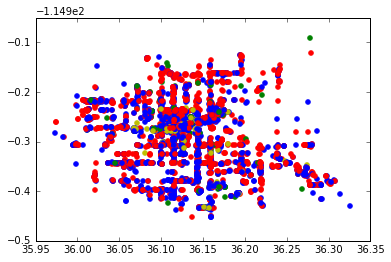

In [77]:
#KMEANS++
kmeans = KMeans(init = 'k-means++', n_clusters = 4)
gmm = mixture.GMM(n_components = 4, covariance_type='diag')
kmeans.fit(vector_arr) 
centroids = kmeans.cluster_centers_
labels= kmeans.labels_ # list of restaurant belonging cluster
#In one of the next shells we use the error method shown in class to evaluate the number of clusters
# I decided that 4 clusters is the best as from 3 to 4 we improve by around 5% error whereas from 4 to 5 by aroun 1-2% which i would say is negligible
restindex = -1
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
for i in labels:
    restindex = restindex + 1
    if i == 0:
        cluster0.append(restindex)
    if i == 1:
        cluster1.append(restindex)
    if i == 2:
        cluster2.append(restindex)
    if i == 3:
        cluster3.append(restindex)

#this funcction decides on the label of the cluster, only though out of the categories     
def labelit(a, b):
    clusterlabel = []
    for j in a:
        for key in b[j]:
            if (b[j])[key] == 1 and key[:11] != 'price range'and key[:8] != 'latitude' and key[:9] != 'longitude' and key[:7] !='takeout':
                clusterlabel.append(key)

    elemcounts = Counter(clusterlabel)
    mostcommon = elemcounts.most_common(1)
    return mostcommon[0][0]

c = labelit(cluster0, data)
print ("The cluster's label defined by the green dots is "+c)
d = labelit(cluster1, data)
print ("The cluster's label defined by the blue dots is "+d)
e = labelit(cluster2, data)
print ("The cluster's label defined by the red dots is "+e)
f = labelit(cluster3, data)
print("The cluster's label defined by the yellow dots is "+f)

colors = ["g.", "b.", "r.", "y.", "c.", "m.", "k.", "w."]

for i in range(len(vector_arr)):
    plt.plot(vector_arr[i][485], vector_arr[i][486], colors[labels[i]], markersize = 10)
    

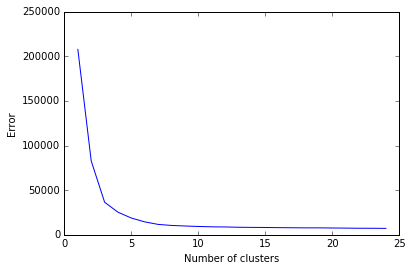

In [69]:
#error function 1
error = np.zeros(25)
error[0] = 0;
for k in range(1,25):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(vector_arr)
    error[k] = kmeans.inertia_

plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('Error')

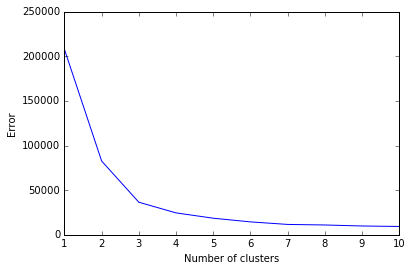

In [70]:
#error function 2
error = np.zeros(11)
error[0] = 0;
for k in range(1,11):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit_predict(vector_arr)
    error[k] = kmeans.inertia_

plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
plt.ylabel('Error')

(0.90820431347854746, array([ 13.42100663,   9.93995641,   9.93995641, ...,  13.42100663,
         9.93995641,  13.42100663]))


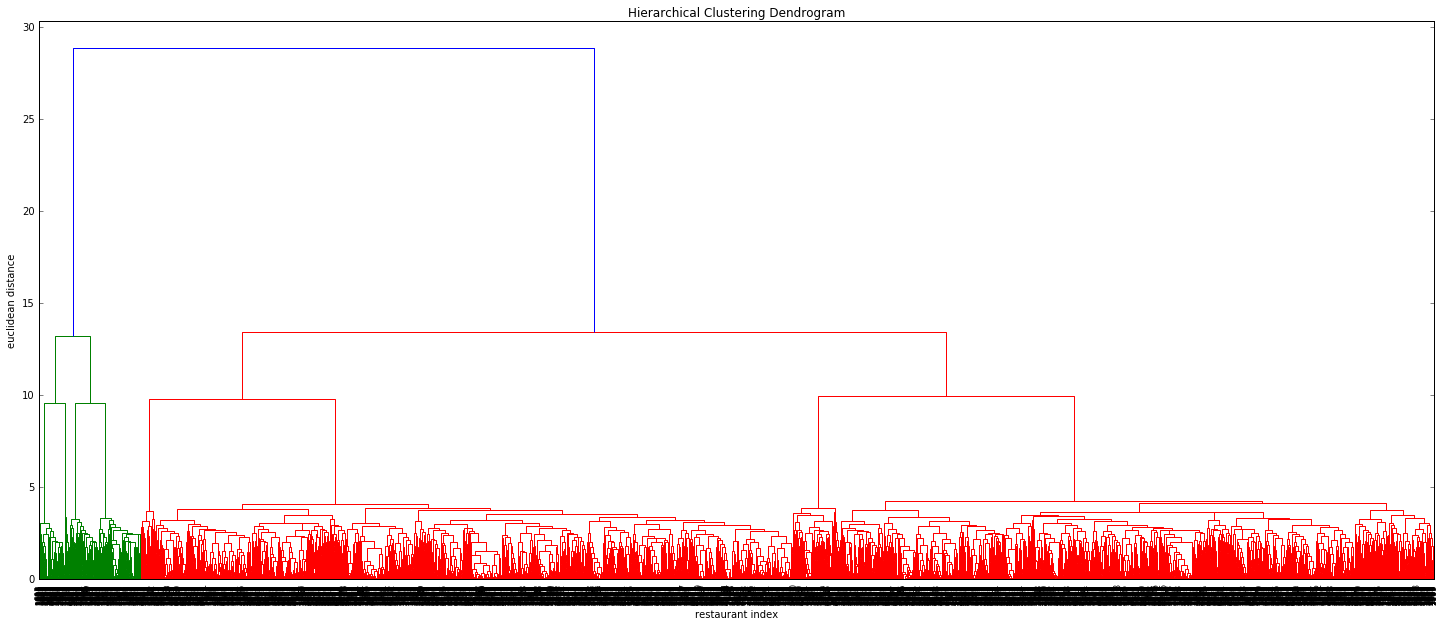

In [86]:
#Hierarchical
hierarch_sp = linkage(vector_arr, method = 'complete', metric = 'euclidean')
coph_dists = cophenet(hierarch_sp, pdist(vector_arr))
print (coph_dists)
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('restaurant index')
plt.ylabel('euclidean distance')

dendrogram(hierarch_sp, leaf_rotation=90., leaf_font_size=8.,)
plt.show()

The cluster's label defined by the green dots is American (Traditional)
The cluster's label defined by the blue dots is Fast Food
The cluster's label defined by the yellow dots is Steakhouses
The cluster's label defined by the cyan dots is Nightlife


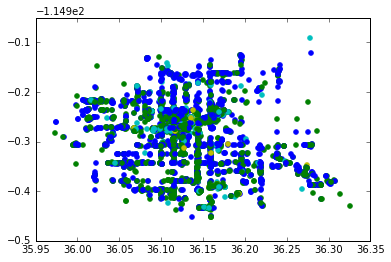

In [76]:
#GMM. Chose 4 clusters because similar with kmeans
gmm.fit(vector_arr)
y_pred =gmm.predict(vector_arr)

restindex = -1
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []

for i in y_pred:
    restindex = restindex + 1
    if i == 0:
        cluster0.append(restindex)
    if i == 1:
        cluster1.append(restindex)
    if i == 2:
        cluster2.append(restindex)
    if i == 3:
        cluster3.append(restindex)

c = labelit(cluster0, data)
print("The cluster's label defined by the green dots is "+c)
d = labelit(cluster1, data)
print("The cluster's label defined by the blue dots is "+d)
e = labelit(cluster2, data)
print("The cluster's label defined by the yellow dots is "+e)

f = labelit(cluster3, data)
print("The cluster's label defined by the cyan dots is "+f)

colors = ["g.", "b.", "y.", "c.", "m.", "k.", "w."]

for i in range(len(vector_arr)):
    plt.plot(vector_arr[i][485], vector_arr[i][486], colors[y_pred[i]], markersize = 10)
    

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

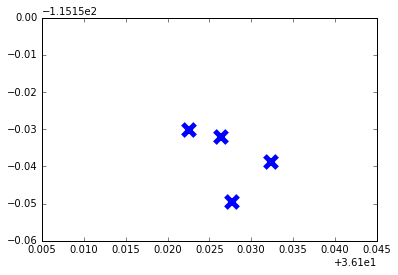

In [82]:
#Centroids of kmeans
for i in range(0,4):
    plt.scatter(centroids[i][485], centroids[i][486], marker = "x", s = 150, linewidths = 5, zorder = 10)

Give a short (detailed) analysis comparing the 3 techniques. **(10 pts)**

In [ ]:
"""
Please read the comments on the code as they are complementary to this analysis.

Gmm and kmeans++ work pretty similarly. Their labels are pretty similar as they will at least have 3/4 labels the same.
Hierarchical does not leave us much of a margin to pick 3 clusters. It is either 2 or 4. That fact supports ou choice of 4 clusters
for kmeans and gmm. I was unable to find a label for hierarchical, and no time to find outliers
"""

-----------------

In [ ]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()